# **Computer Vision Project: Process Results**

*Authors: Rafael Rodríguez & Alba Martínez*

*Master in Machine Learning for Health, 2023~2024*

---

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import t
from scipy.stats import f_oneway
from sklearn.metrics import auc
from itertools import cycle
import os

sns.set_theme()

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
folder_path = '/content/drive/MyDrive/Computer Vision/Proyecto/Outputs'
images_path = '/content/drive/MyDrive/Computer Vision/Proyecto/Images'

# List all files in the folder
files = os.listdir(folder_path)

# Filter CSV files
csv_files = [file for file in files if file.endswith('.csv')]
df_list = []

# Iterate through each CSV file and read it
for file in csv_files:
  print(f"Reading file {file}...")
  file_path = os.path.join(folder_path, file)
  df = pd.read_csv(file_path)
  df_list.append(df)

Reading file tracking_results_KCF.csv...
Reading file tracking_results_CSRT.csv...
Reading file tracking_results_BOOSTING.csv...
Reading file tracking_results_MedianFlow.csv...
Reading file tracking_results_MIL.csv...
Reading file tracking_results_MOSSE.csv...
Reading file tracking_results_TLD.csv...
Reading file tracking_results_GOTURN.csv...
Reading file tracking_results_DaSiamRPN.csv...
Reading file tracking_results_Nano.csv...
Reading file tracking_results_Vit.csv...


### **Succes Plot**

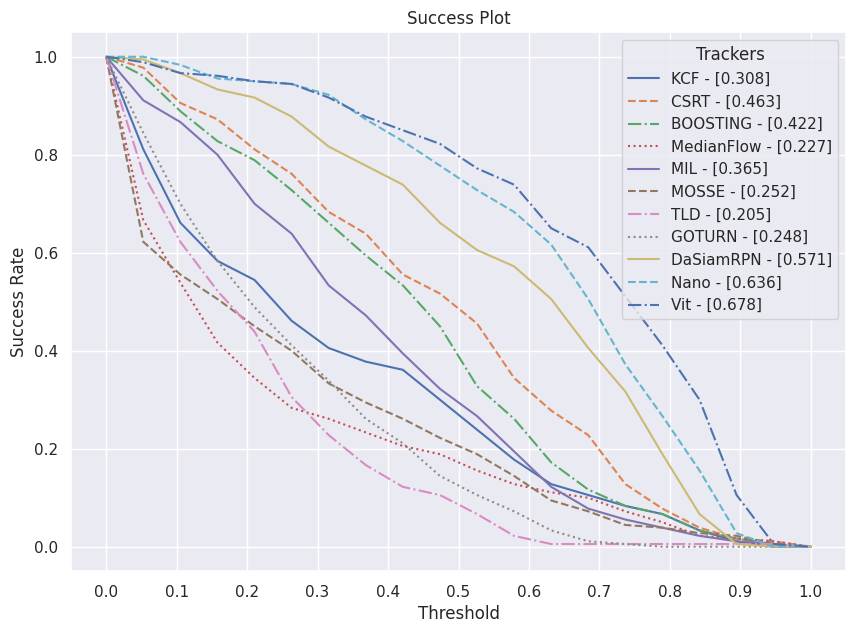

In [4]:
plt.figure(figsize=(10, 7))
thresholds = np.linspace(0.0, 1, 20)
line_styles = cycle(['-', '--', '-.', ':'])

# Iterate over each DataFrame in df_list, calculate the success rate, and plot it
for idx, df in enumerate(df_list, start=1):
    iou_scores = df['Average IoU'].sort_values()
    success_rate = [sum(iou_scores >= threshold) / len(iou_scores) for threshold in thresholds]
    auc_val = auc(thresholds, success_rate)
    tracker = df['Tracker'][0]
    line_style = next(line_styles)
    sns.lineplot(x=thresholds, y=success_rate, label=f'{tracker} - [{auc_val:.3f}]', linestyle=line_style)

# Add labels and title
plt.xticks(np.arange(0.0, 1.1, 0.1))
plt.xlabel('Threshold')
plt.ylabel('Success Rate')
plt.title('Success Plot')
plt.legend(title='Trackers')
plt.grid(True)

plt.savefig(images_path + '/success_plot.svg', format='svg', dpi=2000)
plt.show()

### **Mean IoU and SEM per tracker**

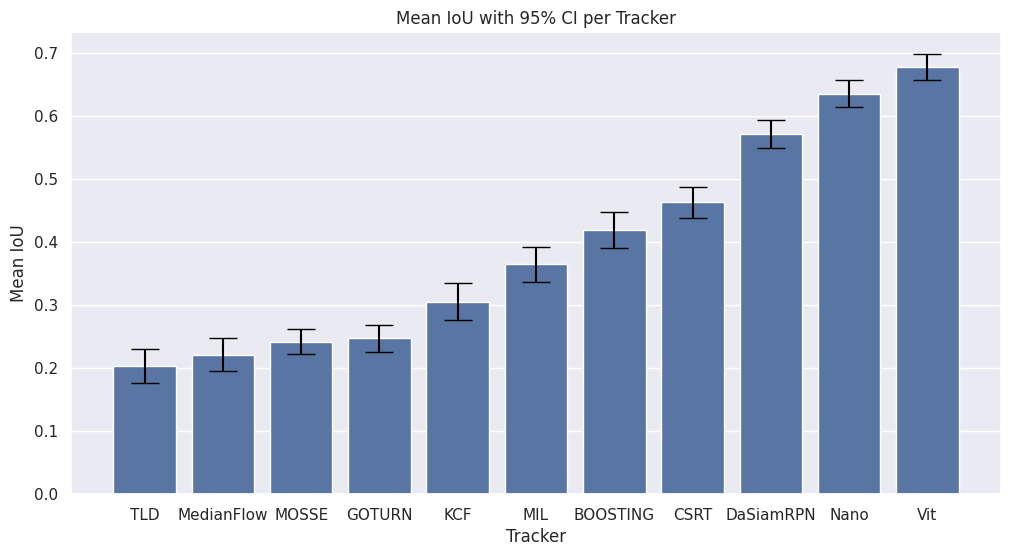

In [5]:
results = []

for df in df_list:
  # Compute mean and std
  mean_iou = df['Average IoU'].mean()
  std_iou = df['STD IoU'].mean()

  # Compute SEM
  sample_size = len(df)
  sem = std_iou / np.sqrt(sample_size)
  ci = 1.96 * sem

  # Save data as a dictionary
  results.append({'Tracker': df['Tracker'][0], 'mean IoU': mean_iou, 'SEM': sem, 'CI': ci})

# Plot the results
results_df = pd.DataFrame(results).sort_values(by='mean IoU')

plt.figure(figsize=(12, 6))
sns.barplot(x='Tracker', y='mean IoU', data=results_df)
for i, row in results_df.iterrows():
    plt.errorbar(x=row['Tracker'], y=row['mean IoU'], yerr=row['CI'], fmt='none', capsize=10, color='black')
plt.title('Mean IoU with 95% CI per Tracker')
plt.xlabel('Tracker')
plt.ylabel('Mean IoU')

plt.savefig(images_path + '/mean_IoU.svg', format='svg', dpi=2000)
plt.show()

In [6]:
iou_values = [df['Average IoU'].values for df in df_list]

# Perform ANOVA test
f_statistic, p_value = f_oneway(*iou_values)
print(f"Global p-value: {p_value}")

Global p-value: 8.899911655247078e-171


In [7]:
latex_table = results_df.to_latex(index=False)

# Write LaTeX table to a .tex file
with open(images_path + '/mean_IoU.tex', 'w') as f:
    f.write(latex_table)

results_df

,Tracker,mean IoU,SEM,CI
6,TLD,0.203934,0.013576,0.026610
3,MedianFlow,0.221821,0.013290,0.026048
5,MOSSE,0.242373,0.009826,0.019258
7,GOTURN,0.247578,0.011012,0.021583
0,KCF,0.305864,0.015206,0.029804
4,MIL,0.365134,0.014348,0.028122
2,BOOSTING,0.419869,0.014328,0.028083
1,CSRT,0.463471,0.012807,0.025101
8,DaSiamRPN,0.571503,0.011369,0.022283
9,Nano,0.636268,0.011136,0.021827


### **Average IoU Stripplot + Violinplot**

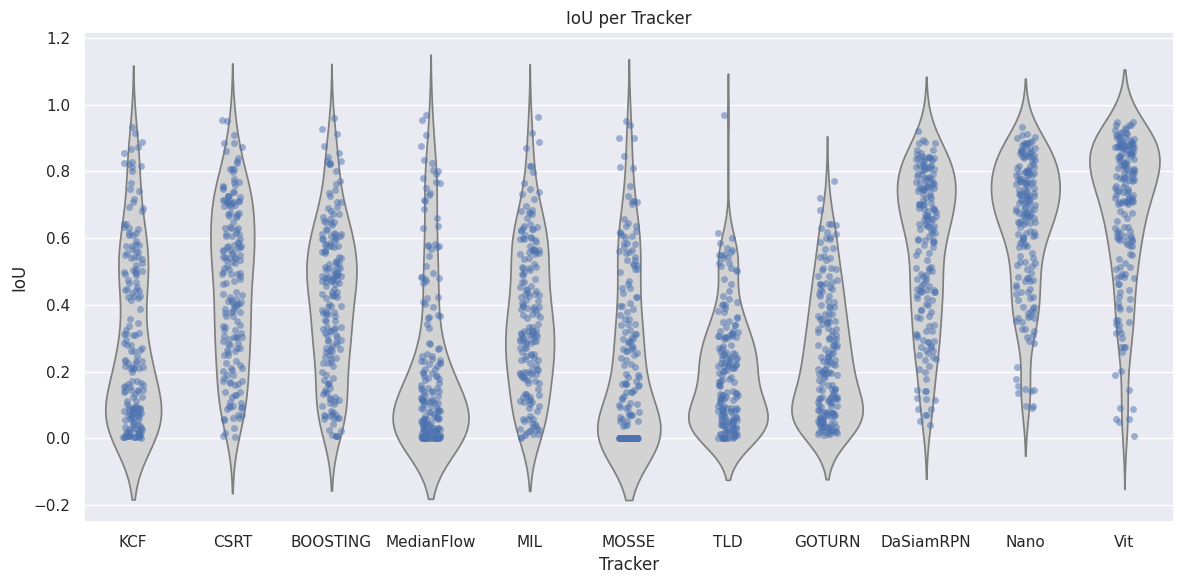

In [13]:
all_data = pd.concat(df_list)

plt.figure(figsize=(12, 6))
sns.violinplot(x='Tracker', y='Average IoU', data=all_data, inner=None, color='lightgray')
sns.stripplot(x='Tracker', y='Average IoU', data=all_data, jitter=True, alpha=.5)
plt.title('IoU per Tracker')
plt.xlabel('Tracker')
plt.ylabel('IoU')
plt.tight_layout()

plt.savefig(images_path + '/IoU_strip_violin.svg', format='svg', dpi=2000)
plt.show()

### **Mean FPS and SEM per Tracker**

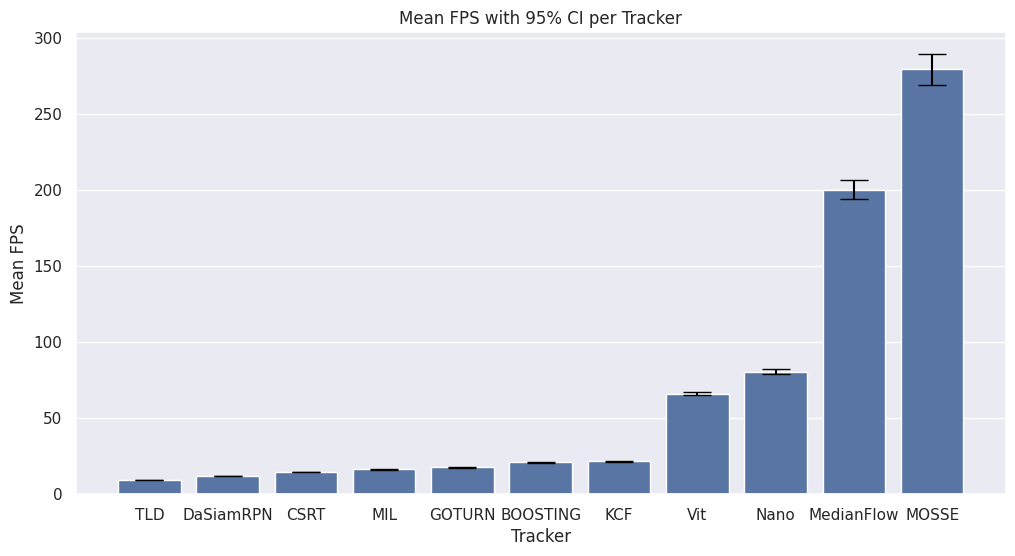

In [9]:
results = []

for df in df_list:
  df_filt = df[df['N Failures'] == 0]

  # Compute mean and std
  mean_fps = df_filt['Average FPS'].mean()
  std_fps = df_filt['STD FPS'].mean()

  # Compute SEM
  sample_size = len(df_filt)
  sem = std_fps / np.sqrt(sample_size)
  ci = 1.96 * sem

  # Save data as a dictionary
  results.append({'Tracker': df['Tracker'][0], 'mean FPS': mean_fps, 'SEM': sem, 'CI': ci, 'Sample Size': sample_size})

# Plot the results
results_df = pd.DataFrame(results).sort_values(by='mean FPS')

plt.figure(figsize=(12, 6))
sns.barplot(x='Tracker', y='mean FPS', data=results_df)
for i, row in results_df.iterrows():
    plt.errorbar(x=row['Tracker'], y=row['mean FPS'], yerr=row['CI'], fmt='none', capsize=10, color='black')
plt.title('Mean FPS with 95% CI per Tracker')
plt.xlabel('Tracker')
plt.ylabel('Mean FPS')

plt.savefig(images_path + '/mean_FPS.png', format='png', dpi=500)
plt.show()

In [10]:
fps_values = [df[df['N Failures'] == 0]['Average FPS'].values for df in df_list]

# Perform ANOVA test
f_statistic, p_value = f_oneway(*fps_values)
print(f"Global p-value: {p_value}")

Global p-value: 3.996082508424789e-89


In [11]:
latex_table = results_df.to_latex(index=False)

# Write LaTeX table to a .tex file
with open(images_path + '/mean_FPS.tex', 'w') as f:
    f.write(latex_table)

results_df

,Tracker,mean FPS,SEM,CI,Sample Size
6,TLD,9.222440,0.084302,0.165231,125
8,DaSiamRPN,11.991278,0.045807,0.089782,180
1,CSRT,14.673335,0.142347,0.278999,147
4,MIL,16.332171,0.197181,0.386475,180
7,GOTURN,17.762692,0.151047,0.296051,180
2,BOOSTING,20.893065,0.142427,0.279157,180
0,KCF,21.572871,0.245828,0.481824,54
10,Vit,66.225394,0.412363,0.808232,180
9,Nano,80.625924,0.736862,1.444249,180
3,MedianFlow,200.324210,3.114177,6.103787,38


### **Tracking Failures per Tracker**

In [12]:
failures_per_tracker = {}
for df in df_list:
    tracker = df['Tracker'][0]
    total_failures = df['N Failures'].sum()
    failures_per_tracker[tracker] = total_failures / len(df)

# Convert the dictionary to a DataFrame
failures_df = pd.DataFrame(list(failures_per_tracker.items()), columns=['Tracker', 'Failures/Video']).sort_values(by='Failures/Video')

latex_table = failures_df.to_latex(index=False)
# Write LaTeX table to a .tex file
with open(images_path + '/failures.tex', 'w') as f:
    f.write(latex_table)

# Display the DataFrame as a table
failures_df

,Tracker,Failures/Video
2,BOOSTING,0.000000
4,MIL,0.000000
7,GOTURN,0.000000
8,DaSiamRPN,0.000000
9,Nano,0.000000
10,Vit,0.000000
6,TLD,4.911111
1,CSRT,7.433333
5,MOSSE,44.100000
3,MedianFlow,44.527778
